In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
from tqdm import tqdm
import scipy.stats as sct
from prose.fluxes import Fluxes
from prose import Sequence, blocks
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
with open('time.dat', 'r') as file:
    lineas = file.readlines()
time = np.zeros(len(lineas))
for i in range(len(lineas)):
    if i==0:
        time[i] = np.nan
    else:
        time[i] = float(lineas[i].strip())

In [3]:
with open('resultado.csv', 'r') as file:
    lineas= file.readlines()

In [4]:
stars_o = []
for i, linea in tqdm(enumerate(lineas)):
    if i == 0:
        header = np.array(linea.split(','), dtype=str) 
    if i > 0:
        valores=linea.split(',')
        lista = []
        for valor in valores:
            if (valor.strip() != '') and (valor.strip() != 'INDEF'):
                lista.append(float(valor))
            
            else:
                lista.append(np.nan)
            
        
        del lista[12] #elimina valor 'separation'
        star = np.array(lista)
        stars_o.append(star)

25693it [01:17, 331.68it/s]


In [5]:
stars = stars_o.copy()

In [6]:
flux = []
mag = []
merr = []
ids = []

for i in tqdm(range(len(stars))):
    ftemp = []
    mgtemp = []
    mrtemp = []
    idtemp = []
    
    for j in range(len(stars[i])):
        
        if j%6 == 0:
            idtemp.append(stars[i][j])
        if j%6 == 3:
            ftemp.append(stars[i][j])   
        if j%6 == 4:
            mgtemp.append(stars[i][j])
        if j%6 == 5:
            mrtemp.append(stars[i][j])  
            
    len_sin_nan = np.count_nonzero(~np.isnan(mgtemp))
    if len_sin_nan >= 63: 
        
        ids.append(np.array(idtemp))
        flux.append(np.array(ftemp))
        mag.append(np.array(mgtemp))
        merr.append(np.array(mrtemp))    

100%|████████████████████████████████████| 25692/25692 [01:33<00:00, 273.82it/s]


In [7]:
desv = []
prom = []
for i in range(len(mag)):
    prom.append(np.nanmean(mag[i]))
    desv.append(np.nanstd(mag[i]))

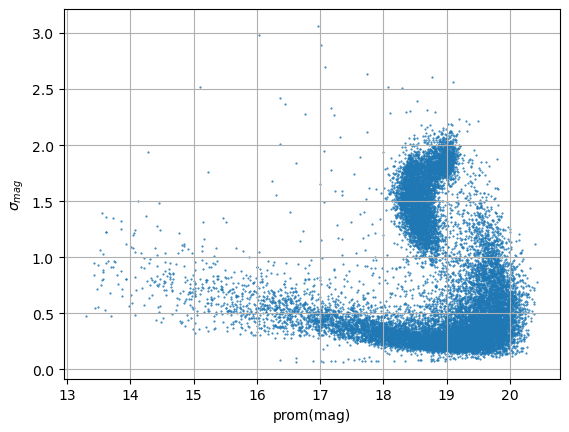

In [13]:
plt.scatter(prom, desv, s=0.25)
plt.xlabel('prom(mag)')
plt.ylabel(r'$\sigma_{mag}$')
plt.grid()

In [8]:
#Aquí se quiere extraer la región de los datos con alto sigma y magnitud, en particular el bulto superior.
def ext_subgrup(mag, merr, flux, ids, prom, desv):
    cx = 18.6   #coordenada central en x del óvalo
    cy = 1.5    #coordenada central en y del óvalo
    wx = 0.8    #radio menor en x
    h = 0.6     #radio mayor en x

    i_add = []
    for i in tqdm(range(len(prom))):
        dentro_del_ovalo = (((prom[i] - cx) ** 2 )/ wx ** 2 + ((desv[i] - cy) ** 2) / h ** 2)
        if dentro_del_ovalo >= 1:
            i_add.append(i)
    
    
    mag1 = []
    merr1 = []
    flux1 = []
    ids1 = []
    prom1 = []
    desv1= []
        
    mag2 = []
    merr2 = []
    flux2 = []
    ids2 = []
    prom2 = []
    desv2= []
    for i in tqdm(range(len(mag))):
        if i not in i_add:
            mag1.append(mag[i])
            merr1.append(merr[i])
            flux1.append(flux[i])
            ids1.append(ids[i])
            prom1.append(prom[i])
            desv1.append(desv[i])
        else:
            mag2.append(mag[i])
            merr2.append(merr[i])
            flux2.append(flux[i])
            ids2.append(ids[i])
            prom2.append(prom[i])
            desv2.append(desv[i])
        
    return mag1, merr1, flux1, ids1, prom1, desv1, mag2, merr2, flux2, ids2, prom2, desv2

In [9]:
#defino coordenadas del óvalo
mag1, merr1, flux1, ids1, prom1, desv1, mag2, merr2, flux2, ids2, prom2, desv2 = ext_subgrup(mag, merr, flux, ids, prom, desv)

100%|███████████████████████████████████| 18742/18742 [00:02<00:00, 7523.62it/s]


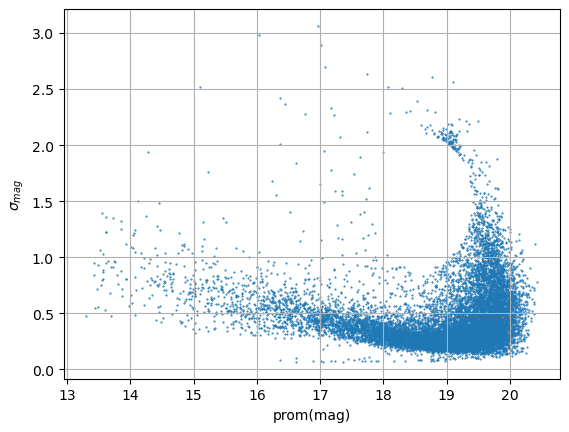

In [10]:
plt.scatter(prom2, desv2, s=0.25)
plt.xlabel('prom(mag)')
plt.ylabel(r'$\sigma_{mag}$')
plt.grid()

In [11]:
#Calculo errores de flujo
err1 = []
for i in tqdm(range(len(flux1))):
    errlis = []
    for j in range(len(flux1[i])):
        
        error= flux1[i][j]*merr1[i][j]/1.0857
        errlis.append(error)
        
    err1.append(np.array(errlis))

100%|██████████████████████████████████████| 5690/5690 [00:06<00:00, 903.65it/s]


In [12]:
len(flux2)

13052

In [13]:
#prose por revisar
raw_fluxes = Fluxes(fluxes = flux2, time = time, errors = errors)
raw_fluxes.target = 3000
nan_stars = np.any(np.isnan(raw_fluxes.fluxes), axis=(0, 2))# stars with nan fluxes
fluxes = raw_fluxes.mask_stars(~nan_stars)
diff_fluxes2 = raw_fluxes.diff()
diff_fluxes2.plot()
diff_fluxes2.bin(1, True).errorbar()
plt.grid()


KeyboardInterrupt



In [14]:
def ext_subgrup(mag, merr, flux, ids, prom, desv):
    
    i_add = []
    for i in tqdm(range(len(prom))):
        if (desv[i] > -0.1*prom[i]+2.3) and (desv[i]> prom[i] - 18.5):
            i_add.append(i)
        
    mag3 = []
    merr3 = []
    flux3 = []
    ids3 = []
    prom3 = []
    desv3= []
    for i in tqdm(range(len(mag))):
        if i in i_add:
            mag3.append(mag[i])
            merr3.append(merr[i])
            flux3.append(flux[i])
            ids3.append(ids[i])
            prom3.append(prom[i])
            desv3.append(desv[i])
        
    return mag3, merr3, flux3, ids3, prom3, desv3

In [15]:
mag3, merr3, flux3, ids3, prom3, desv3  = ext_subgrup(mag2, merr2, flux2, ids2, prom2, desv2)

100%|██████████████████████████████████| 13052/13052 [00:00<00:00, 25647.88it/s]


In [16]:
x = np.linspace(18.5, 21, 1000)
y = x - 18.5

x2 = np.linspace(13, 20, 1000)
y2 = -x2*0.1 + 2.3

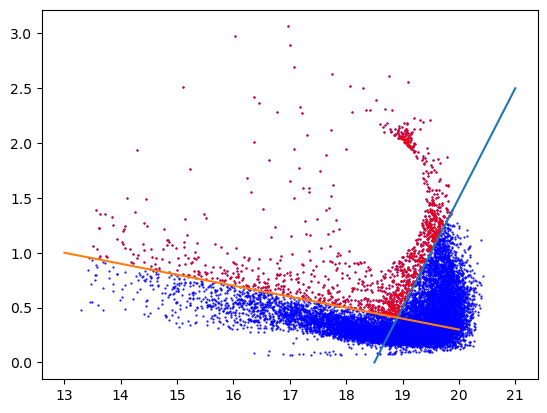

In [21]:
plt.plot(x,y)
plt.plot(x2,y2)
plt.scatter(prom2, desv2, s=0.3, c= 'b')
plt.scatter(prom3, desv3, s=0.3, c='r')

In [ ]:
pp = PdfPages('MT_set3.pdf')

def func_plot(x,y,i):
    plt.figure()
    plt.clf()
    
    plt.scatter(x,y, s=0.8, c='k')
    plt.xlabel('JD')
    plt.ylabel('Flujo')
    plt.title(f'ID_{i}_set(3)')
    pp.savefig()
    
for i in tqdm(range(len(ids3))):
    func_plot(time, mag3[i], i)
    
pp.close()

  2%|▋                                        | 20/1256 [00:06<03:23,  6.07it/s]/tmp/ipykernel_4278/3084650585.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|███████████████████████████████████████| 1256/1256 [04:07<00:00,  5.08it/s]
